# Sudoku Solver

### Done by: Michaela Klug, Tristen Haverly

### Student Numbers: 2393033, 1864691

In [423]:
#imports

import cv2
import numpy as np
import skimage
from matplotlib import pyplot as plt
import numpy as np
from skimage import io
from skimage.io import imread, imshow
from scipy.ndimage import binary_fill_holes
import matplotlib.pyplot as plt
from skimage import exposure
import scipy.fftpack as fp
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import opening,closing,square,dilation,disk,binary_dilation,binary_opening,binary_erosion
from skimage import filters
from skimage.segmentation import flood_fill
from skimage.morphology import convex_hull_image

### Read in sudoku image

(-0.5, 959.5, 1279.5, -0.5)

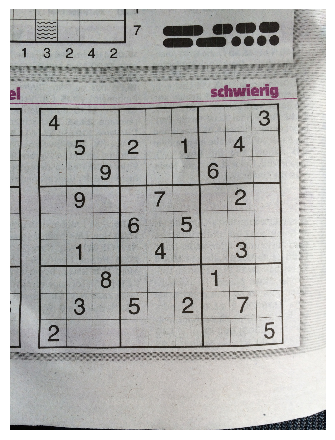

In [424]:
#read in image
sud = imread('Images/try2.jpg', as_gray=False)
#display sudoku 
imshow(sud)
plt.axis('off')

### Convert image to grayscale

(-0.5, 959.5, 1279.5, -0.5)

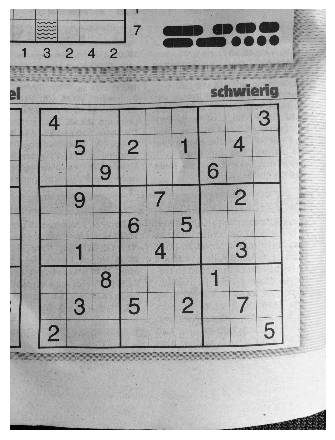

In [425]:
#convert image to grayscale
gray_sud = rgb2gray(sud)
#display grayscale image
imshow(gray_sud)
plt.axis('off')

### Threshold grayscale image using Otsu's method- convert image into binary representation

(-0.5, 959.5, 1279.5, -0.5)

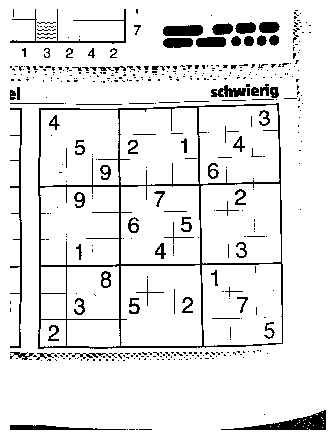

In [426]:
#get the threhold usign otsu's method
thresh = threshold_otsu(gray_sud)
#perform thresholding on grayscale image to obtain binary image
binary= gray_sud > thresh
#display binary image
imshow(binary,cmap='gray')
plt.axis('off')


(-0.5, 959.5, 1279.5, -0.5)

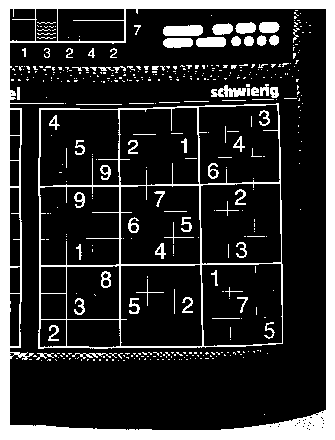

In [427]:
#invert binary image. Black pixels --> white and white pixels --> black
inv = np.invert(binary)
#display inverted binary image
imshow(inv,cmap='gray')
plt.axis('off')

### Fill region of grid using binary_fill_holes

(-0.5, 959.5, 1279.5, -0.5)

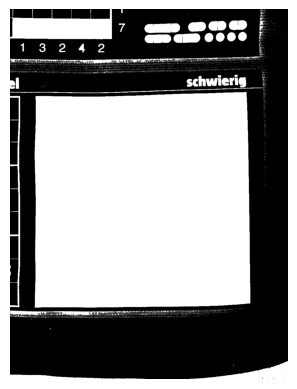

In [428]:
#fill in the region of the grid using binary_fill _holes (will fill in other parts as well)
#adaptation of the flood-fill operation for binary images
img_fill_holes = binary_fill_holes(inv).astype(int) # fills in gaps of foreground (white) pixels
#display result
plt.imshow(img_fill_holes, cmap='gray')
plt.axis('off')

### Perform an opening on the image to isolate the grid area

(-0.5, 959.5, 1279.5, -0.5)

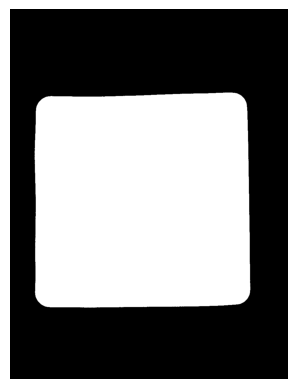

In [429]:
#perform the opening on the image- remove smaller details and noise
#the larger grid shape should remain
opened = binary_opening(img_fill_holes, disk(50)) #mention why not square, but rather disk
#display result of opening
plt.imshow(opened, cmap='gray')
plt.axis('off')

### Get convex hull of grid square

In [430]:
#Get convex hull
chull = convex_hull_image(opened)

### Find co-ordinates of the four corners of the convex hull

In [431]:
#Use numpy to get coordinates of pixels in the convex hull
coords = np.column_stack(np.where(chull > 0))

#Get the extreme points of the convex hull in the image
top_left = np.amin(coords, axis=0)
bottom_right = np.amax(coords, axis=0)
bottom_left = [bottom_right[0], top_left[1]]
top_right = [top_left[0], bottom_right[1]]

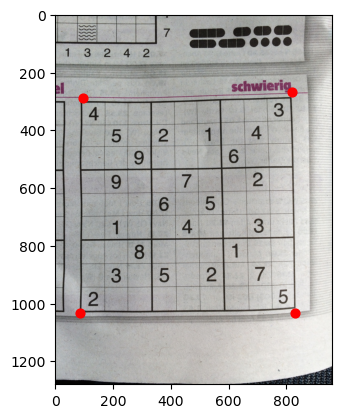

In [432]:
#Plot the extreme points on the image:
import matplotlib.pyplot as plt
plt.imshow(sud)
plt.scatter(top_left[1]+10, top_left[0], c='r', s=40)
plt.scatter(bottom_right[1], bottom_right[0], c='r', s=40)
plt.scatter(bottom_left[1], bottom_left[0], c='r', s=40)
plt.scatter(top_right[1]-10 , top_right[0] - 20, c='r', s=40)
plt.show()

### Crop the grayscale image to the square defined by the extreme points of the convex hull

(-0.5, 763.5, 762.5, -0.5)

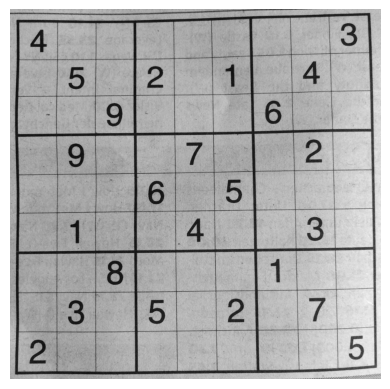

In [433]:
#Crop the image using the extreme points:
cropped = gray_sud[top_left[0]-10:bottom_right[0]+10, top_left[1]-10:bottom_right[1]+10]
#cropped version of inverse of the grayscale image used later
cropinv=inv[top_left[0]-10:bottom_right[0]+10, top_left[1]-10:bottom_right[1]+10]
plt.imshow(cropped,cmap='gray')
plt.axis('off')

### Perform hysteresis thresholidng on cropped image to detect edges

(-0.5, 763.5, 762.5, -0.5)

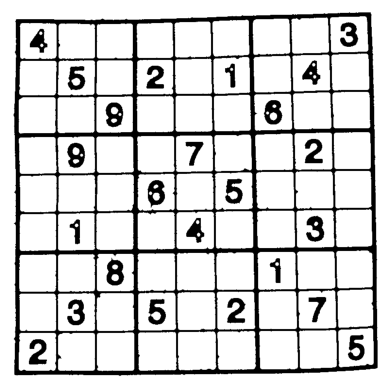

In [434]:
#set low threshold value
low = 0.05

#set high threshold value
high = 0.38

#detect edges using sobel filter
edges = filters.sobel(cropped)

#perform hysteresis thresholding
lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hys = filters.apply_hysteresis_threshold(edges, low, high)

#take the inverted image
hys=np.invert(hys)

#perform an opening on the inverted image to fill in gaps in the edges
opened = opening(hys,disk(3))

#display the result- should be the grid and some numbers
plt.imshow(opened,cmap='gray')
plt.axis('off')

### Remove the grid lines from the image

(-0.5, 763.5, 762.5, -0.5)

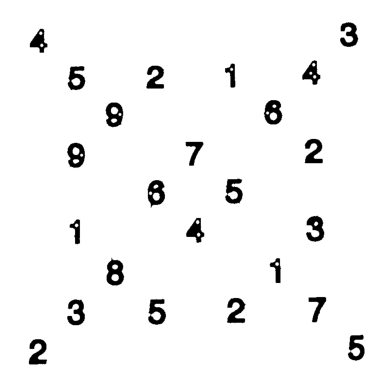

In [435]:
#loop through the pixels in the image to find the first pixel of the outer grid
#this gives us the seed point for flood filling
x,y=opened.shape
seedx=0
seedy=0
breaknow=False
for i in range(x):
    for j in range(y):
        #False means pixel is black
        if opened[i][j]==False:
            #assign seed point coordinates
            seedx=i
            seedy=j
            breaknow=True
            break
    #break out of nested loop as soon as first black pixel found
    if(breaknow==True):
        break
#perform the flood filling with seedpoint (seedx,seedy) and assign value 1 to filled region
no_grid = flood_fill(opened, (seedx,seedy), 1)
#display image with no grid
plt.imshow(no_grid, cmap='gray')
plt.axis('off')

### Take the difference of the opened image and the image with the grid removed- only the grid should remain

(-0.5, 763.5, 762.5, -0.5)

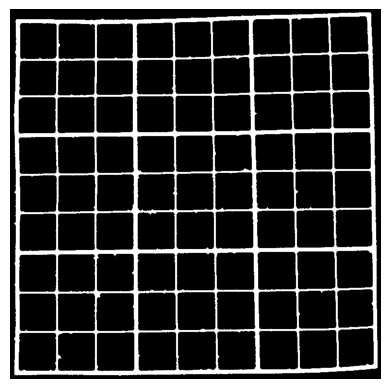

In [436]:
#difference obtained by performing a bitwise xor on the 2 images
diff=np.bitwise_xor(opened, no_grid)

#display result- should just be grid
plt.imshow(diff,cmap='gray')
plt.axis('off')

### Perform a dilation on the grid to thicken the lines and make them clearer for contour detection

(-0.5, 763.5, 762.5, -0.5)

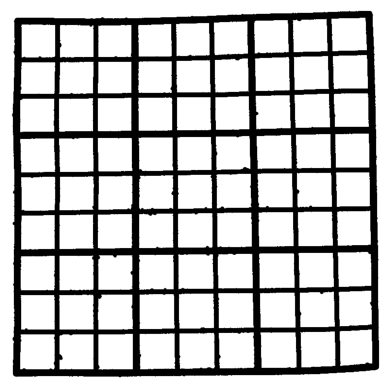

In [437]:
#perform a bionary dilation (dilation of binary image)
thickGrid=binary_dilation(diff, disk(3))

#get inverted result
thickGrid=np.invert(thickGrid)

#display inverted result with thicker lines
plt.imshow(thickGrid,cmap='gray')
plt.axis('off')

### Get contours of the grid

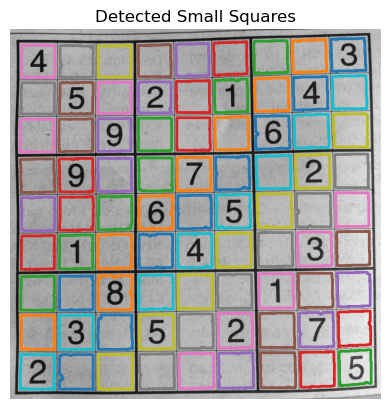

In [438]:
#get contours
contours = skimage.measure.find_contours(thickGrid, 0.8)

#list of small squares in big grid
squares = []
for contour in contours:
    area = len(contour)
    #boundaries based on the size of the small squares
    if area > 200 and area<500:  
        squares.append(contour)

#display cropped grayscale image
fig, ax = plt.subplots()
ax.imshow(cropped, cmap='gray')

#need to sort contours in order in which they appear in image (top down, left to right)

#list to store a lists- where the first element of every inner list is the contour and the second element is the top left corner of that contour
toSort=[]
for i, square in enumerate(squares):

    subList=[]

    #draw polygon creates a binary mask representing the polygon/contour
    #rr, cc are arrays of row and column coordinates of the vertices of the polygon
    rr, cc = skimage.draw.polygon(square[:, 0], square[:, 1])

    #get top left coordinate of each contour
    topleft=[np.min(rr),np.min(cc)]

    #add contour and its top left corner to the sublist
    subList.append(square)
    subList.append(topleft)

    #append sublist into the list which needs to be sorted
    toSort.append(subList)

#slice the toSort list into 9 groups (each groups contains 9 sublists)
#this collects all those sublists whose top left corners are most similar to each other
#i.e collects all the contours which appear in the same row
divided = [toSort[i:i+9] for i in range(0, len(toSort), 9)]

#sort each sublist according to the y coordinate of the top left corner of the contour
#this order the row contours in order in which they appear in the row
for sl in divided:
    sl.sort(key=lambda x: x[1][1])
   
#plot the small squares/contours on the image
for square in squares:
    ax.plot(square[:, 1], square[:, 0], linewidth=2)
first=squares[len(squares)-1]
ax.set_axis_off()

plt.title('Detected Small Squares')
plt.show()


### Store whether each small square in the grid is empty or occupied (has a number in it) and display the small sqaures in the grid shape

[['occupied' 'empty' 'empty' 'empty' 'empty' 'empty' 'empty' 'empty'
  'occupied']
 ['empty' 'occupied' 'empty' 'occupied' 'empty' 'occupied' 'empty'
  'occupied' 'empty']
 ['empty' 'empty' 'occupied' 'empty' 'empty' 'empty' 'occupied' 'empty'
  'empty']
 ['empty' 'occupied' 'empty' 'empty' 'occupied' 'empty' 'empty'
  'occupied' 'empty']
 ['empty' 'empty' 'empty' 'occupied' 'empty' 'occupied' 'empty' 'empty'
  'empty']
 ['empty' 'occupied' 'empty' 'empty' 'occupied' 'empty' 'empty'
  'occupied' 'empty']
 ['empty' 'empty' 'occupied' 'empty' 'empty' 'empty' 'occupied' 'empty'
  'empty']
 ['empty' 'occupied' 'empty' 'occupied' 'empty' 'occupied' 'empty'
  'occupied' 'empty']
 ['occupied' 'empty' 'empty' 'empty' 'empty' 'empty' 'empty' 'empty'
  'occupied']]


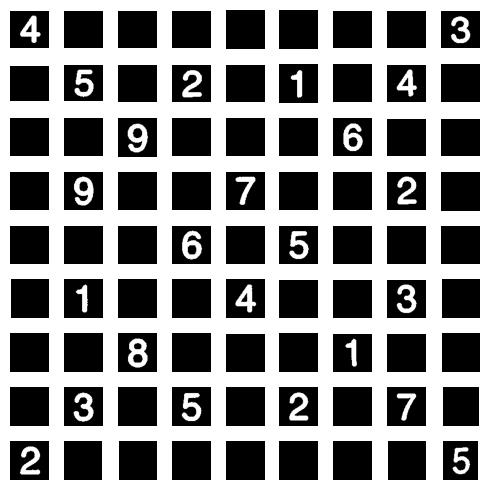

In [439]:
fig,axes = plt.subplots(nrows=9, ncols=9, figsize=(5,5), sharex=False, sharey=False)
ax=axes.ravel()

#this list contains the value for each small square saying if it is empty or occupied (has a number in it)
emptiness=[]
#this list stores the processed small squares/blocks
blocks=[]

#iterate through the ordered contours
#go through each row of contours
for row in range(9):
    rowOfSquares=divided[row] #row of contours
    for ind, sublist in enumerate(rowOfSquares):
        square=sublist[0] #get contour element of each sublist 

        #draw polygon creates a binary mask representing the polygon/contour
        #rr, cc are arrays of row and column coordinates of the vertices of the polygon
        rr, cc = skimage.draw.polygon(square[:, 0], square[:, 1])

        #crop the cropped version of the inverted input to the coordinates specified by the specific contour
        #this 'extracts' each small square of the sudoku grid
        cropped_image = cropinv[np.min(rr):np.max(rr), np.min(cc):np.max(cc)]

        #erode image to get smallest number of white pixels required (so we can work out the sum of the image more accurately)
        eroded = skimage.morphology.binary_erosion(cropped_image, disk(1))
        #dilate the image again to make the digits thicker to imrpove the performnace of the digit prediciton model
        dilated = skimage.morphology.binary_dilation(eroded, disk(2))

        #add the dilated image to the list
        blocks.append(dilated)
        
        #calculate the sum of the eroded image
        #it was decided that a sum in [0,100] means the cell is empty
        if 0<=np.sum(eroded) and np.sum(eroded)<=100:
            emptiness.append("empty")
        else:
            #otherwise there is a white digit in the cell
            emptiness.append("occupied")
        
        #display small square
        ax[(row*9)+ind].imshow(dilated,cmap='gray')

#convert the emptiness list into a numpy array
arr = np.array(emptiness)
# Reshape the array to 9 x 9 shape
reshaped_emptiness = arr.reshape(9, 9)
#print the reshaped emptiness array
print(reshaped_emptiness)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### The machine learning model to predict the digit in each cell

In [440]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

# Save the trained model
model.save('digit_recognition_model.h5')


Epoch 1/10
469/469 [==============================] - 13s 26ms/step - loss: 0.3768 - accuracy: 0.8856 - val_loss: 0.0642 - val_accuracy: 0.9800
Epoch 2/10
 24/469 [>.............................] - ETA: 11s - loss: 0.1443 - accuracy: 0.9544

KeyboardInterrupt: 

### Save the small squares as images to be passed into the above model

In [ ]:
#create a list to store image paths
image_paths = []
for i, image in enumerate(blocks):
    #get a different filename for each image
    filename = f"Squares/image_{i}.png"
    
    #save the image using the  filename
    image=img_as_ubyte(image)
    io.imsave(filename, image)
    
    #add the image path to the list of paths
    image_paths.append(filename)


C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_0.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_1.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_2.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_3.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_5.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Squares/image_6.png is a low contrast image
  io.imsave(filename, image)
C:\Users\msklu\AppData\Local\Temp\ipykernel_18376\1778000727.py:9: UserWarning: Sq

### Finally, loop through each of the small squares: if it is empty, print '-', otherwise pass the image into the model and print the predicted digit

In [ ]:
#initialise a 9x9 grid of zeros for the output
finalGrid = [[0] * 9 for _ in range(9)] 

#loop through the reshaped emptiness array to see if the cell is empty or not
#if it is not empty, obtain the corresponding image from the imgpath array
#pass the image through the model and generate the digit prediction
for i in range(9):
    for j in range(9):
        if reshaped_emptiness[i][j]=='empty':
            finalGrid[i][j]="-"
        else:
            index=i * 9 + j #obtain linearised position in imgage_paths array
            imgpath=image_paths[index]
            dig=cv2.imread(imgpath) #read in the image
            gray = cv2.cvtColor(dig, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (28, 28))
            normalized = resized / 255.0
            reshaped = np.reshape(normalized, (1, 28, 28, 1))
            predictions = model.predict(reshaped, verbose=None)
            recognized_digit = np.argmax(predictions)
            finalGrid[i][j]=recognized_digit
        
for p in range(9):
    for t in range(9):
        print(finalGrid[p][t],end=" ")
    print("\n")



- - - - 5 - - - - 

- - 5 7 - 6 3 - - 

- 8 - - 8 - - 4 - 

- 4 - - 1 - - 3 - 

9 - 8 - - - 5 - 1 

- 1 - - 7 - - 8 - 

- 6 - - 3 - - 8 - 

- - 7 6 - 8 2 - - 

- - - - 4 - - - - 

